In [62]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from tqdm import tqdm
from collections import Counter, defaultdict
from random import sample
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch import Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [64]:
data_flag = 'dermamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [67]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

BATCH_SIZE = 128

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
valid_dataset = DataClass(split='val', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)

# sampler
targets = train_dataset.labels.squeeze()
class_sample_count = np.array([np.sum(targets == t) for t in np.unique(targets)])
weights = 1. / class_sample_count
samples_weights = weights[targets]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=8, sampler=sampler)
val_loader = DataLoader(dataset=valid_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)

In [68]:
Counter(label[0] for _, label in train_dataset)

Counter({np.int64(5): 4693,
         np.int64(4): 779,
         np.int64(2): 769,
         np.int64(1): 359,
         np.int64(0): 228,
         np.int64(6): 99,
         np.int64(3): 80})

Klasy są niezbalansowane coś trzeba zrobić przy klasyfikatorze i generatorze chyba też?

In [69]:
label_to_images = defaultdict(list)

for img, label in test_dataset:
    class_idx = label[0]
    label_to_images[class_idx].append(img)

In [70]:
class MedModel(nn.Module):
    def __init__(self, num_labels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Get ResNet50 model with ImageNet weights
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        # freeze convolution parameters
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        # Fully connected layer with num_labels classes
        self.model.fc = nn.Linear(num_ftrs, num_labels)

    def forward(self, x):
        return self.model(x)

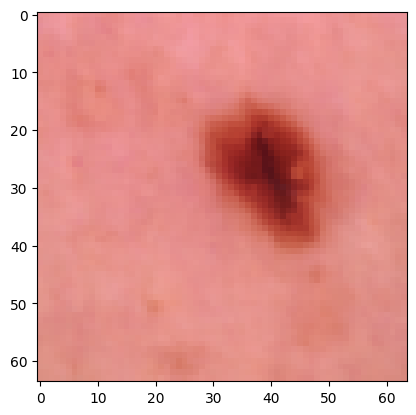

In [124]:
def denormalize(tensor):
    return (tensor+1)/2

def plot_decoded(tensor, get_tensor=False):
    img = denormalize(tensor.detach())
    if get_tensor:
        return img
    # print(img)
    plt.imshow(img.permute(1, 2, 0).numpy())

plot_decoded(valid_dataset[0][0])

In [80]:
model = MedModel(n_classes)
model = model.to(device)

# model

In [73]:
def compute_class_weights(train_loader, num_classes):
    class_counts = np.zeros(num_classes)
    
    for _, labels in train_loader:
        for label in labels:
            class_counts[label] += 1
            
    total_samples = len(train_loader.dataset)
    class_weights = total_samples / (num_classes * class_counts)
    
    return torch.tensor(class_weights, dtype=torch.float).to(device)

In [81]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=compute_class_weights(train_loader, n_classes))
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [82]:
def accuracy(loader, loader_type):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze(1)
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} {loader_type} images: {100 * correct / total:.2f} %')
    return 100 * correct / total

In [83]:
def accuracy_sepearate(loader):
    model.eval()

    correct = defaultdict(int)
    total = defaultdict(int)
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze(1)
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            for label, pred in zip(labels, predicted):
                label = label.item()
                total[label] += 1
                correct[label] += pred.item() == label
    return [round(100*c/t,2) for c, t in zip(correct.values(), total.values())]

In [84]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[%d/{num_epochs}] loss: %.3f' %
          (epoch+1 ,  running_loss / len(train_dataset)))
    accuracy(train_loader, 'train')
    accuracy(val_loader, 'valid')
    running_loss = 0.0

print('Finished Training')

100%|██████████| 55/55 [00:07<00:00,  7.58it/s]

[1/20] loss: 0.012


Accuracy of the network on the 7007 train images: 61.27 %
Accuracy of the network on the 1003 valid images: 57.03 %


100%|██████████| 55/55 [00:04<00:00, 11.30it/s]

[2/20] loss: 0.010


Accuracy of the network on the 7007 train images: 69.67 %
Accuracy of the network on the 1003 valid images: 54.74 %


100%|██████████| 55/55 [00:04<00:00, 11.78it/s]

[3/20] loss: 0.008


Accuracy of the network on the 7007 train images: 72.38 %
Accuracy of the network on the 1003 valid images: 58.33 %


100%|██████████| 55/55 [00:07<00:00,  7.67it/s]

[4/20] loss: 0.007


Accuracy of the network on the 7007 train images: 76.21 %
Accuracy of the network on the 1003 valid images: 59.12 %


100%|██████████| 55/55 [00:04<00:00, 11.67it/s]

[5/20] loss: 0.007


Accuracy of the network on the 7007 train images: 77.59 %
Accuracy of the network on the 1003 valid images: 60.92 %


100%|██████████| 55/55 [00:04<00:00, 11.79it/s]

[6/20] loss: 0.006


Accuracy of the network on the 7007 train images: 80.03 %
Accuracy of the network on the 1003 valid images: 61.12 %


100%|██████████| 55/55 [00:07<00:00,  7.67it/s]

[7/20] loss: 0.006


Accuracy of the network on the 7007 train images: 81.05 %
Accuracy of the network on the 1003 valid images: 60.52 %


100%|██████████| 55/55 [00:04<00:00, 11.70it/s]

[8/20] loss: 0.006


Accuracy of the network on the 7007 train images: 82.37 %
Accuracy of the network on the 1003 valid images: 63.31 %


100%|██████████| 55/55 [00:04<00:00, 11.78it/s]

[9/20] loss: 0.006


Accuracy of the network on the 7007 train images: 83.19 %
Accuracy of the network on the 1003 valid images: 61.42 %


100%|██████████| 55/55 [00:04<00:00, 11.73it/s]

[10/20] loss: 0.005


Accuracy of the network on the 7007 train images: 83.30 %
Accuracy of the network on the 1003 valid images: 63.61 %


100%|██████████| 55/55 [00:04<00:00, 11.70it/s]

[11/20] loss: 0.005


Accuracy of the network on the 7007 train images: 84.33 %
Accuracy of the network on the 1003 valid images: 61.71 %


100%|██████████| 55/55 [00:04<00:00, 11.77it/s]

[12/20] loss: 0.005


Accuracy of the network on the 7007 train images: 85.41 %
Accuracy of the network on the 1003 valid images: 64.21 %


100%|██████████| 55/55 [00:04<00:00, 11.73it/s]

[13/20] loss: 0.005


Accuracy of the network on the 7007 train images: 86.46 %
Accuracy of the network on the 1003 valid images: 61.81 %


100%|██████████| 55/55 [00:04<00:00, 11.71it/s]

[14/20] loss: 0.005


Accuracy of the network on the 7007 train images: 86.11 %
Accuracy of the network on the 1003 valid images: 61.91 %


100%|██████████| 55/55 [00:04<00:00, 11.79it/s]

[15/20] loss: 0.005


Accuracy of the network on the 7007 train images: 86.24 %
Accuracy of the network on the 1003 valid images: 63.21 %


100%|██████████| 55/55 [00:04<00:00, 11.78it/s]

[16/20] loss: 0.004


Accuracy of the network on the 7007 train images: 87.34 %
Accuracy of the network on the 1003 valid images: 63.21 %


100%|██████████| 55/55 [00:04<00:00, 11.74it/s]

[17/20] loss: 0.004


Accuracy of the network on the 7007 train images: 87.30 %
Accuracy of the network on the 1003 valid images: 62.61 %


100%|██████████| 55/55 [00:04<00:00, 11.83it/s]

[18/20] loss: 0.004


Accuracy of the network on the 7007 train images: 87.04 %
Accuracy of the network on the 1003 valid images: 62.71 %


100%|██████████| 55/55 [00:04<00:00, 11.75it/s]

[19/20] loss: 0.004


Accuracy of the network on the 7007 train images: 88.23 %
Accuracy of the network on the 1003 valid images: 62.01 %


100%|██████████| 55/55 [00:04<00:00, 11.73it/s]

[20/20] loss: 0.004


Accuracy of the network on the 7007 train images: 87.90 %
Accuracy of the network on the 1003 valid images: 62.81 %
Finished Training


In [85]:
accuracy(test_loader, 'test')

Accuracy of the network on the 2005 test images: 62.19 %


62.19451371571072

In [125]:
# torch.save(model, 'real_trained_classifier_sampler.pth')
classifier_real = torch.load('real_trained_classifier_sampler.pth', weights_only=False).to(device)

In [89]:
latent_dim = 100
embedding_dim = 100

In [98]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_channel = 2

        self.label_conditioned_generator = nn.Sequential(
            nn.Embedding(n_classes, embedding_dim),
            nn.Linear(embedding_dim, 16*self.label_channel)
        )

        self.latent = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            # input: (B, 513, 4, 4)
            nn.ConvTranspose2d(512 + self.label_channel, 512, 4, 2, 1, bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, self.label_channel, 4, 4)

        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)

        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

In [107]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
         
     
        self.label_condition_disc = \
        nn.Sequential(
            nn.Embedding(n_classes, embedding_dim),
            nn.Linear(embedding_dim, 3*64*64)
        )
              
        self.model = \
        nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
            nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
            nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
            nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            # nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
 
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 64, 64)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        return self.model(concat)

In [108]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [104]:
binary_cross_entropy = torch.nn.BCELoss()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [109]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [110]:
num_epochs = 100
for epoch in range(1, num_epochs+1): 
 
    D_loss_list, G_loss_list = [], []
    
    for i, (real_images, labels) in enumerate(tqdm(train_loader)):
        optimizer_D.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()
 
       
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
       
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
     
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
         
        
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)
 
     
        # train with fake
        #D_fake_loss.backward()
       
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
       
        D_total_loss.backward()
        optimizer_D.step()
 
        # Train generator with real labels
        optimizer_G.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)
 
        G_loss.backward()
        optimizer_G.step()

    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, num_epochs, i+1, len(train_loader), D_total_loss.item(), G_loss.item())
    )

100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


[Epoch: 2/100] [Batch: 55/55] [D loss: 0.673217] [G loss: 0.870477]


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


[Epoch: 3/100] [Batch: 55/55] [D loss: 0.698957] [G loss: 0.746040]


100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


[Epoch: 4/100] [Batch: 55/55] [D loss: 0.692977] [G loss: 0.731497]


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


[Epoch: 5/100] [Batch: 55/55] [D loss: 0.669387] [G loss: 0.719198]


100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


[Epoch: 6/100] [Batch: 55/55] [D loss: 0.626092] [G loss: 0.838414]


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


[Epoch: 7/100] [Batch: 55/55] [D loss: 0.657549] [G loss: 0.766921]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 8/100] [Batch: 55/55] [D loss: 0.695372] [G loss: 0.760232]


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


[Epoch: 9/100] [Batch: 55/55] [D loss: 0.664372] [G loss: 0.772261]


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


[Epoch: 10/100] [Batch: 55/55] [D loss: 0.699521] [G loss: 0.748811]


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


[Epoch: 11/100] [Batch: 55/55] [D loss: 0.683477] [G loss: 0.803698]


100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


[Epoch: 12/100] [Batch: 55/55] [D loss: 0.669480] [G loss: 0.761496]


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


[Epoch: 13/100] [Batch: 55/55] [D loss: 0.690608] [G loss: 0.717279]


100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


[Epoch: 14/100] [Batch: 55/55] [D loss: 0.676429] [G loss: 0.786962]


100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


[Epoch: 15/100] [Batch: 55/55] [D loss: 0.689357] [G loss: 0.736363]


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


[Epoch: 16/100] [Batch: 55/55] [D loss: 0.694212] [G loss: 0.723546]


100%|██████████| 55/55 [00:23<00:00,  2.29it/s]


[Epoch: 17/100] [Batch: 55/55] [D loss: 0.698174] [G loss: 0.721901]


100%|██████████| 55/55 [00:24<00:00,  2.27it/s]


[Epoch: 18/100] [Batch: 55/55] [D loss: 0.676545] [G loss: 0.714240]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 19/100] [Batch: 55/55] [D loss: 0.696732] [G loss: 0.778073]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 20/100] [Batch: 55/55] [D loss: 0.690592] [G loss: 0.727443]


100%|██████████| 55/55 [00:24<00:00,  2.25it/s]


[Epoch: 21/100] [Batch: 55/55] [D loss: 0.694126] [G loss: 0.710392]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 22/100] [Batch: 55/55] [D loss: 0.673251] [G loss: 0.751162]


100%|██████████| 55/55 [00:23<00:00,  2.38it/s]


[Epoch: 23/100] [Batch: 55/55] [D loss: 0.688507] [G loss: 0.719387]


100%|██████████| 55/55 [00:24<00:00,  2.24it/s]


[Epoch: 24/100] [Batch: 55/55] [D loss: 0.680447] [G loss: 0.725574]


100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


[Epoch: 25/100] [Batch: 55/55] [D loss: 0.690687] [G loss: 0.727329]


100%|██████████| 55/55 [00:23<00:00,  2.36it/s]


[Epoch: 26/100] [Batch: 55/55] [D loss: 0.675756] [G loss: 0.725667]


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


[Epoch: 27/100] [Batch: 55/55] [D loss: 0.690215] [G loss: 0.735329]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


[Epoch: 28/100] [Batch: 55/55] [D loss: 0.684927] [G loss: 0.723435]


100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


[Epoch: 29/100] [Batch: 55/55] [D loss: 0.680987] [G loss: 0.745959]


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


[Epoch: 30/100] [Batch: 55/55] [D loss: 0.686859] [G loss: 0.757009]


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


[Epoch: 31/100] [Batch: 55/55] [D loss: 0.682561] [G loss: 0.734563]


100%|██████████| 55/55 [00:24<00:00,  2.25it/s]


[Epoch: 32/100] [Batch: 55/55] [D loss: 0.676792] [G loss: 0.741985]


100%|██████████| 55/55 [00:24<00:00,  2.27it/s]


[Epoch: 33/100] [Batch: 55/55] [D loss: 0.671253] [G loss: 0.740189]


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


[Epoch: 34/100] [Batch: 55/55] [D loss: 0.660165] [G loss: 0.763843]


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


[Epoch: 35/100] [Batch: 55/55] [D loss: 0.655349] [G loss: 0.758552]


100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


[Epoch: 36/100] [Batch: 55/55] [D loss: 0.669409] [G loss: 0.760021]


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


[Epoch: 37/100] [Batch: 55/55] [D loss: 0.659043] [G loss: 0.778570]


100%|██████████| 55/55 [00:23<00:00,  2.36it/s]


[Epoch: 38/100] [Batch: 55/55] [D loss: 0.654893] [G loss: 0.814680]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 39/100] [Batch: 55/55] [D loss: 0.635406] [G loss: 0.787906]


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


[Epoch: 40/100] [Batch: 55/55] [D loss: 0.653453] [G loss: 0.787648]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 41/100] [Batch: 55/55] [D loss: 0.635786] [G loss: 0.799012]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 42/100] [Batch: 55/55] [D loss: 0.631198] [G loss: 0.814329]


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


[Epoch: 43/100] [Batch: 55/55] [D loss: 0.631279] [G loss: 0.818672]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 44/100] [Batch: 55/55] [D loss: 0.642393] [G loss: 0.845776]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 45/100] [Batch: 55/55] [D loss: 0.609076] [G loss: 0.855857]


100%|██████████| 55/55 [00:21<00:00,  2.62it/s]


[Epoch: 46/100] [Batch: 55/55] [D loss: 0.614706] [G loss: 0.859570]


100%|██████████| 55/55 [00:23<00:00,  2.34it/s]


[Epoch: 47/100] [Batch: 55/55] [D loss: 0.626830] [G loss: 0.844020]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 48/100] [Batch: 55/55] [D loss: 0.635384] [G loss: 0.892124]


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


[Epoch: 49/100] [Batch: 55/55] [D loss: 0.587295] [G loss: 0.917794]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 50/100] [Batch: 55/55] [D loss: 0.596684] [G loss: 0.903556]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 51/100] [Batch: 55/55] [D loss: 0.540920] [G loss: 0.924067]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 52/100] [Batch: 55/55] [D loss: 0.588488] [G loss: 0.927358]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 53/100] [Batch: 55/55] [D loss: 0.533394] [G loss: 1.001696]


100%|██████████| 55/55 [00:20<00:00,  2.62it/s]


[Epoch: 54/100] [Batch: 55/55] [D loss: 0.602807] [G loss: 0.925451]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 55/100] [Batch: 55/55] [D loss: 0.528872] [G loss: 0.999162]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 56/100] [Batch: 55/55] [D loss: 0.550517] [G loss: 1.030147]


100%|██████████| 55/55 [00:20<00:00,  2.66it/s]


[Epoch: 57/100] [Batch: 55/55] [D loss: 0.553190] [G loss: 1.016275]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 58/100] [Batch: 55/55] [D loss: 0.510335] [G loss: 1.049785]


100%|██████████| 55/55 [00:23<00:00,  2.30it/s]


[Epoch: 59/100] [Batch: 55/55] [D loss: 0.538324] [G loss: 1.026015]


100%|██████████| 55/55 [00:21<00:00,  2.61it/s]


[Epoch: 60/100] [Batch: 55/55] [D loss: 0.543816] [G loss: 1.009862]


100%|██████████| 55/55 [00:23<00:00,  2.35it/s]


[Epoch: 61/100] [Batch: 55/55] [D loss: 0.519429] [G loss: 1.042428]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 62/100] [Batch: 55/55] [D loss: 0.564811] [G loss: 0.998768]


100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


[Epoch: 63/100] [Batch: 55/55] [D loss: 0.527642] [G loss: 1.095498]


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


[Epoch: 64/100] [Batch: 55/55] [D loss: 0.519197] [G loss: 1.051081]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 65/100] [Batch: 55/55] [D loss: 0.514865] [G loss: 1.162623]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 66/100] [Batch: 55/55] [D loss: 0.508293] [G loss: 1.225314]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 67/100] [Batch: 55/55] [D loss: 0.497399] [G loss: 1.240854]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 68/100] [Batch: 55/55] [D loss: 0.418131] [G loss: 1.223580]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 69/100] [Batch: 55/55] [D loss: 0.525857] [G loss: 1.128343]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 70/100] [Batch: 55/55] [D loss: 0.483500] [G loss: 1.117357]


100%|██████████| 55/55 [00:20<00:00,  2.64it/s]


[Epoch: 71/100] [Batch: 55/55] [D loss: 0.462606] [G loss: 1.172265]


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


[Epoch: 72/100] [Batch: 55/55] [D loss: 0.437489] [G loss: 1.367535]


100%|██████████| 55/55 [00:20<00:00,  2.65it/s]


[Epoch: 73/100] [Batch: 55/55] [D loss: 0.425140] [G loss: 1.330142]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 74/100] [Batch: 55/55] [D loss: 0.421675] [G loss: 1.314198]


100%|██████████| 55/55 [00:24<00:00,  2.29it/s]


[Epoch: 75/100] [Batch: 55/55] [D loss: 0.393167] [G loss: 1.488703]


100%|██████████| 55/55 [00:20<00:00,  2.69it/s]


[Epoch: 76/100] [Batch: 55/55] [D loss: 0.447145] [G loss: 1.230162]


100%|██████████| 55/55 [00:24<00:00,  2.26it/s]


[Epoch: 77/100] [Batch: 55/55] [D loss: 0.460872] [G loss: 1.316720]


100%|██████████| 55/55 [00:23<00:00,  2.37it/s]


[Epoch: 78/100] [Batch: 55/55] [D loss: 0.473940] [G loss: 1.359760]


100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


[Epoch: 79/100] [Batch: 55/55] [D loss: 0.420240] [G loss: 1.298871]


100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


[Epoch: 80/100] [Batch: 55/55] [D loss: 0.381008] [G loss: 1.285354]


100%|██████████| 55/55 [00:22<00:00,  2.43it/s]


[Epoch: 81/100] [Batch: 55/55] [D loss: 0.404867] [G loss: 1.385322]


100%|██████████| 55/55 [00:20<00:00,  2.69it/s]


[Epoch: 82/100] [Batch: 55/55] [D loss: 0.423297] [G loss: 1.393771]


100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


[Epoch: 83/100] [Batch: 55/55] [D loss: 0.429874] [G loss: 1.429883]


100%|██████████| 55/55 [00:22<00:00,  2.45it/s]


[Epoch: 84/100] [Batch: 55/55] [D loss: 0.418412] [G loss: 1.416628]


100%|██████████| 55/55 [00:20<00:00,  2.69it/s]


[Epoch: 85/100] [Batch: 55/55] [D loss: 0.440875] [G loss: 1.415858]


100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


[Epoch: 86/100] [Batch: 55/55] [D loss: 0.442881] [G loss: 1.378461]


100%|██████████| 55/55 [00:22<00:00,  2.41it/s]


[Epoch: 87/100] [Batch: 55/55] [D loss: 0.376487] [G loss: 1.346340]


100%|██████████| 55/55 [00:20<00:00,  2.68it/s]


[Epoch: 88/100] [Batch: 55/55] [D loss: 0.473920] [G loss: 1.413464]


100%|██████████| 55/55 [00:24<00:00,  2.27it/s]


[Epoch: 89/100] [Batch: 55/55] [D loss: 0.461073] [G loss: 1.472662]


100%|██████████| 55/55 [00:23<00:00,  2.32it/s]


[Epoch: 90/100] [Batch: 55/55] [D loss: 0.448933] [G loss: 1.399115]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


[Epoch: 91/100] [Batch: 55/55] [D loss: 0.412267] [G loss: 1.428563]


100%|██████████| 55/55 [00:23<00:00,  2.31it/s]


[Epoch: 92/100] [Batch: 55/55] [D loss: 0.391747] [G loss: 1.327312]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 93/100] [Batch: 55/55] [D loss: 0.362266] [G loss: 1.725931]


100%|██████████| 55/55 [00:20<00:00,  2.67it/s]


[Epoch: 94/100] [Batch: 55/55] [D loss: 0.449353] [G loss: 1.429727]


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]


[Epoch: 95/100] [Batch: 55/55] [D loss: 0.386260] [G loss: 1.519244]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 96/100] [Batch: 55/55] [D loss: 0.455917] [G loss: 1.475566]


100%|██████████| 55/55 [00:23<00:00,  2.34it/s]


[Epoch: 97/100] [Batch: 55/55] [D loss: 0.413911] [G loss: 1.627151]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 98/100] [Batch: 55/55] [D loss: 0.312820] [G loss: 1.642263]


100%|██████████| 55/55 [00:20<00:00,  2.63it/s]


[Epoch: 99/100] [Batch: 55/55] [D loss: 0.401297] [G loss: 1.583644]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 100/100] [Batch: 55/55] [D loss: 0.334791] [G loss: 1.863451]


100%|██████████| 55/55 [00:23<00:00,  2.33it/s]


[Epoch: 101/100] [Batch: 55/55] [D loss: 0.366764] [G loss: 1.313339]


In [ ]:
# torch.save(generator, 'sec_gen1.pth')
# torch.save(discriminator, 'sec_dis1.pth')

# generator = torch.load('sec_gen.pth')
# discriminator = torch.load('sec_dis.pth')

In [112]:
def generate_images(samples=1, only_class=-1):
    generator.eval()
    with torch.no_grad():
        images = []
        for _ in range(samples):
            for label in range(n_classes):
                noise_vector = torch.randn(1, latent_dim, device=device)
                label_tensor = torch.tensor([[label if only_class==-1 else only_class]], dtype=torch.long, device=device)

                prediction = generator([noise_vector, label_tensor])
                images.append([prediction, label_tensor.cpu()])

    return images

In [113]:
import matplotlib.pyplot as plt
import torch

def show_images(images, n, title):
    fig, axes = plt.subplots(1, 7, figsize=(20, 3))

    for idx, img in enumerate(images):
        img_normalized = denormalize(img)
        
        ax = axes[idx]
        ax.imshow(img_normalized.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f"{title} images for class {n}: {test_dataset.info['label'][str(n)]}")
    
    plt.show()

In [114]:
def check_class(n):
    # generated
    generated= [img for img, _ in generate_images(only_class=n)]
    generated = torch.cat(generated, dim=0)

    # real
    real = sample(label_to_images[n], 7)

    show_images(generated, n, 'generated')
    show_images(real, n, 'real')

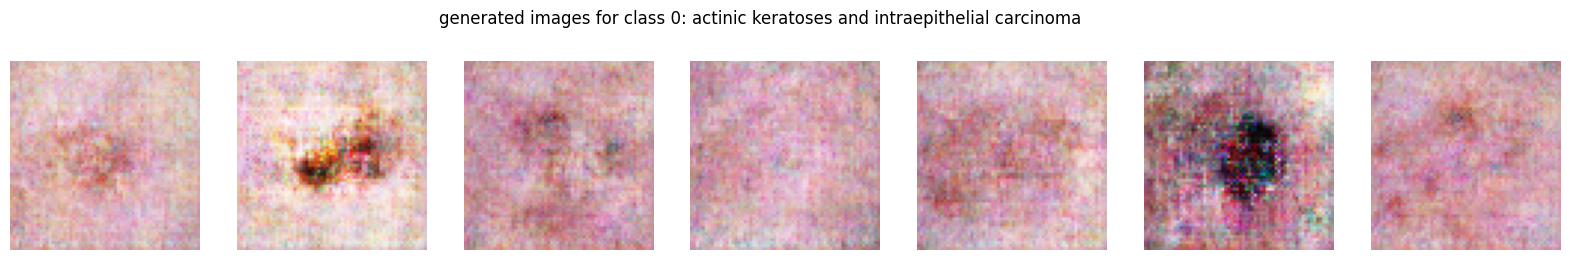

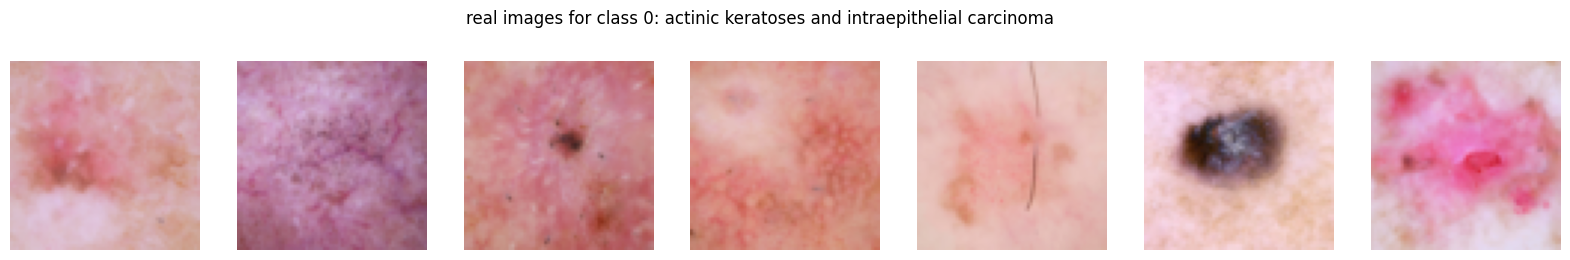

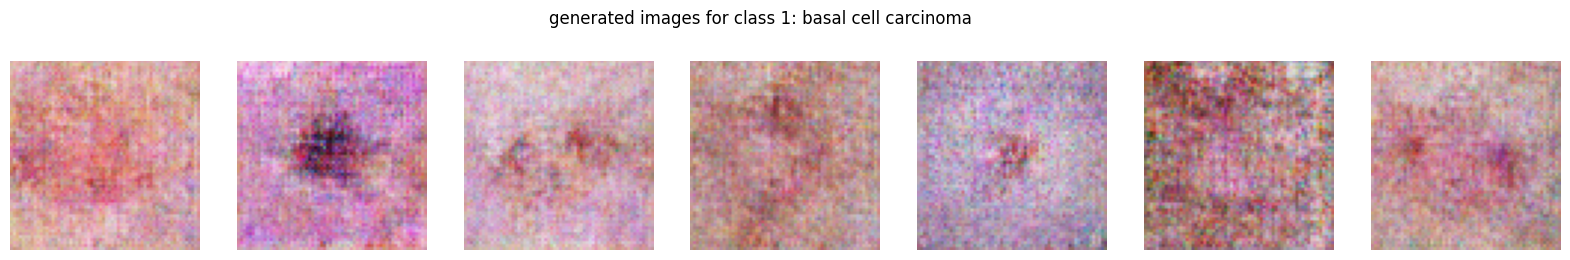

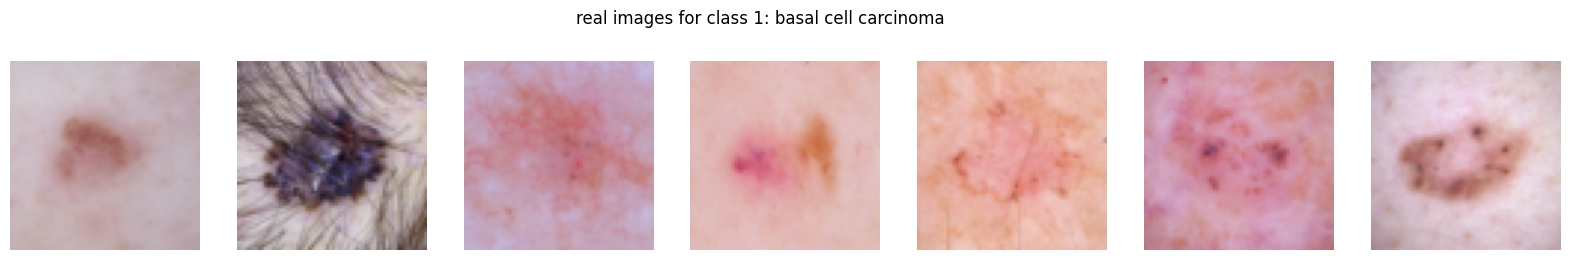

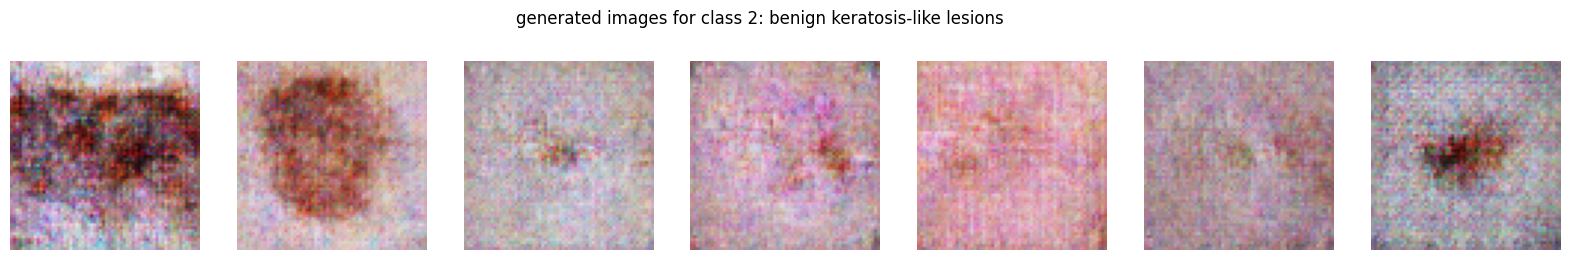

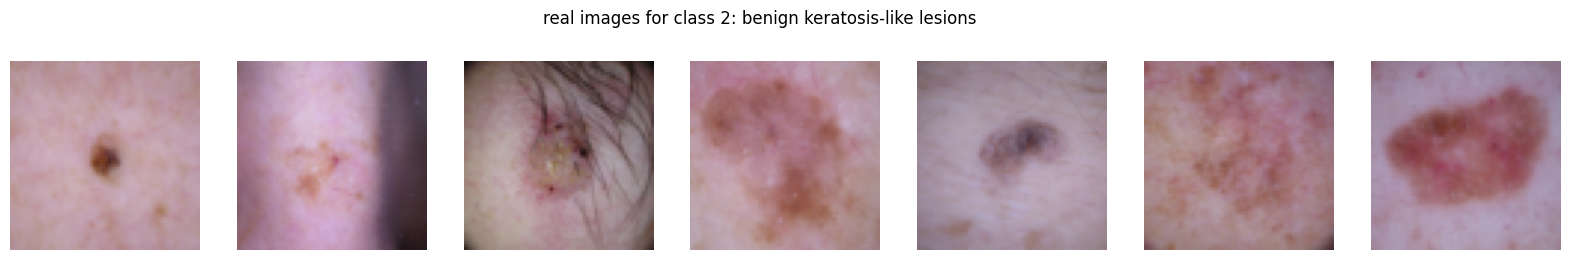

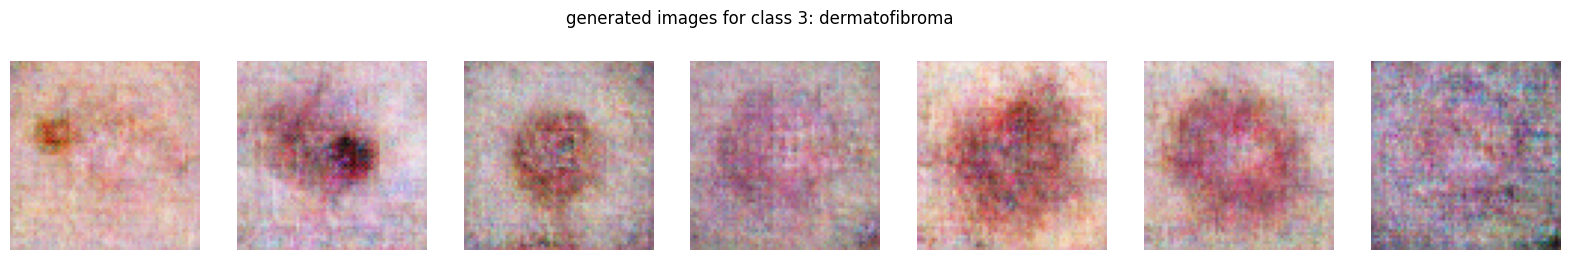

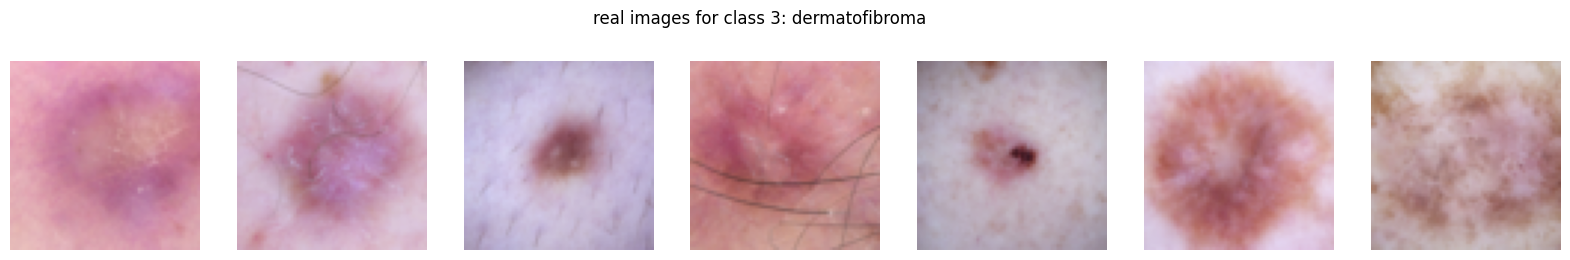

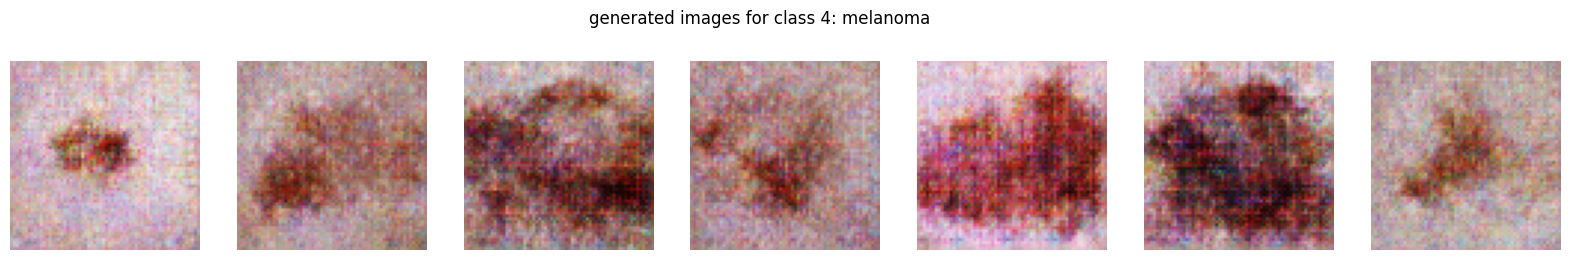

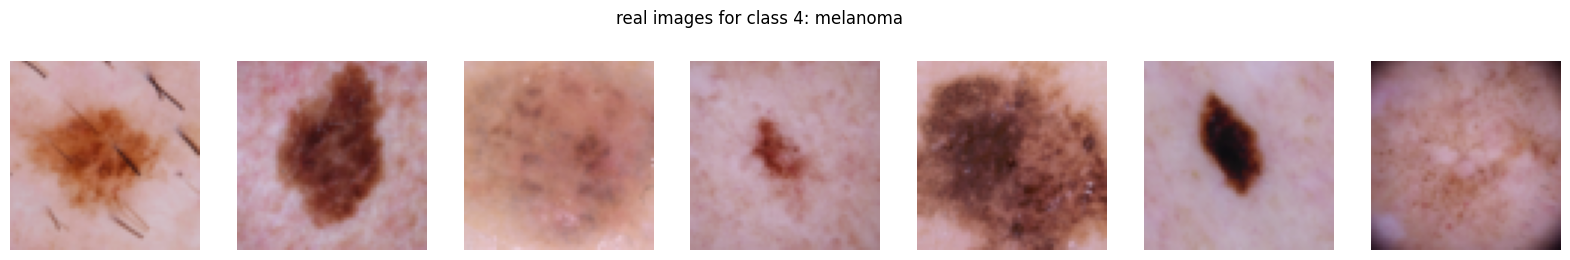

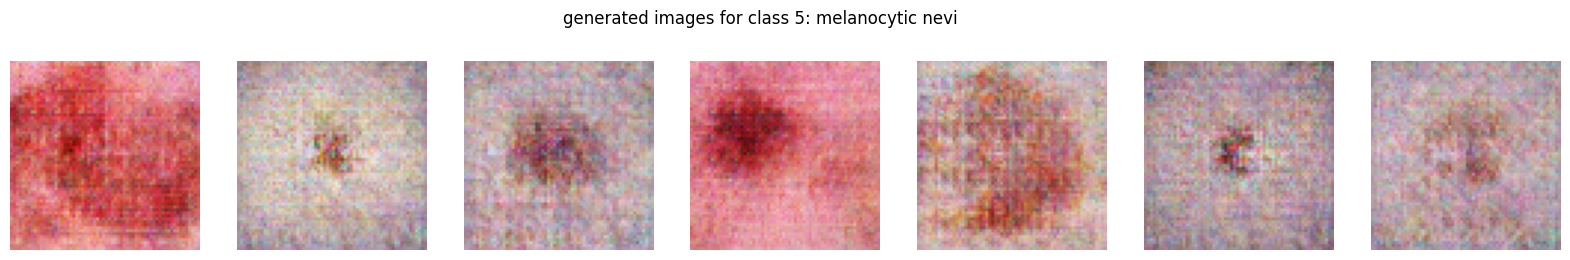

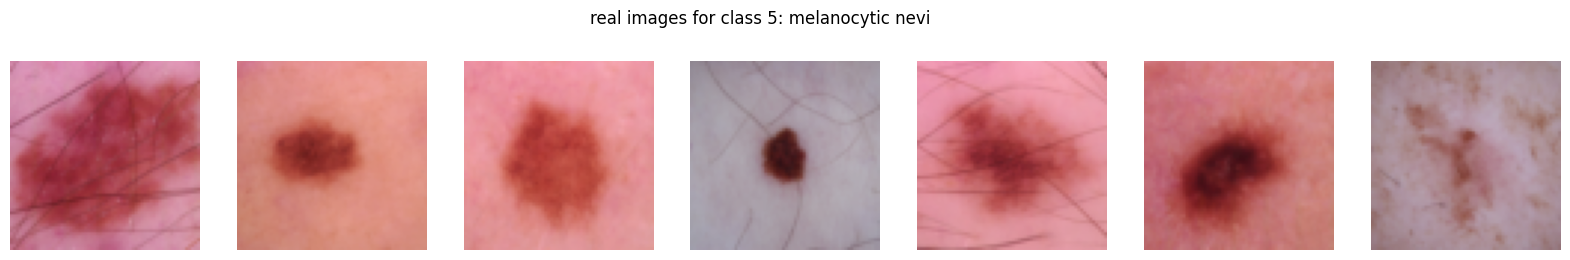

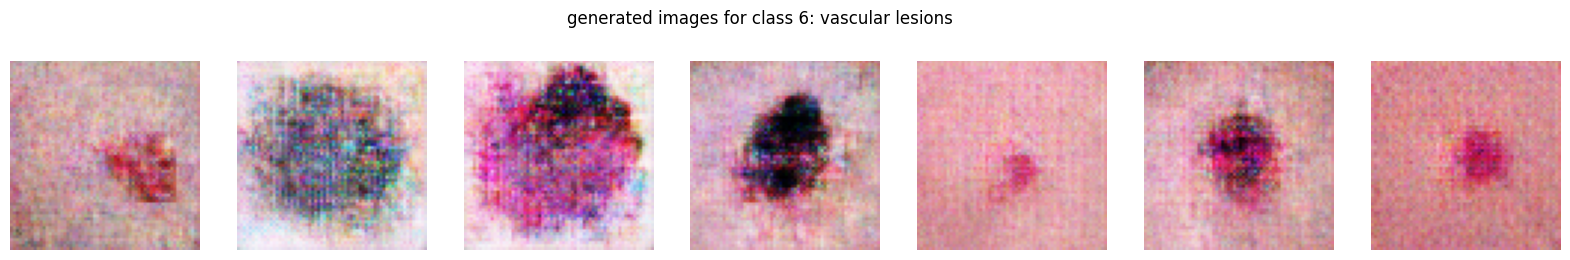

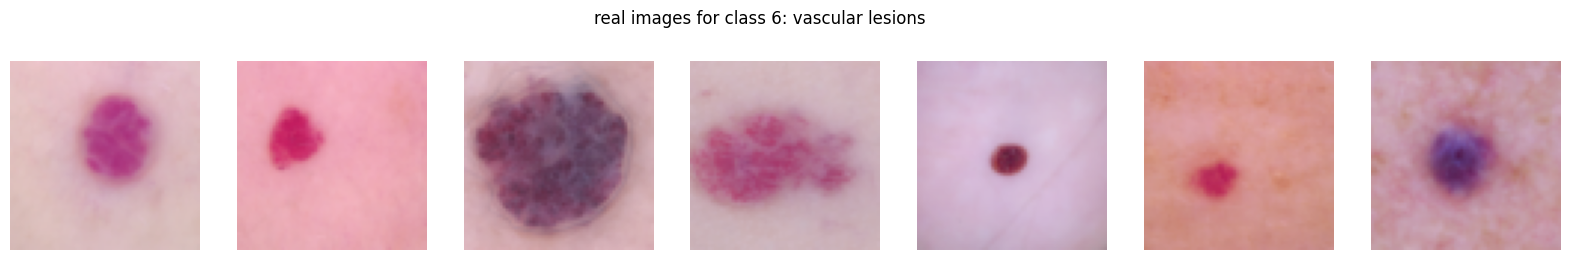

In [115]:
for i in range(7):
    check_class(i)

### Wyniki dla poprzedniego

In [288]:
results = []

for i in range(7):
    results.append(accuracy(generate_images(20, i), f"class {i}"))

print("Mean accuracy: ", round(sum(results)/7, 2), "%")

Accuracy of the network on the 140 class 0 images: 1.43 %
Accuracy of the network on the 140 class 1 images: 10.71 %
Accuracy of the network on the 140 class 2 images: 36.43 %
Accuracy of the network on the 140 class 3 images: 17.86 %
Accuracy of the network on the 140 class 4 images: 20.71 %
Accuracy of the network on the 140 class 5 images: 51.43 %
Accuracy of the network on the 140 class 6 images: 21.43 %
Mean accuracy:  22.86 %


### Wyniki dla nowego

In [117]:
results = []

for i in range(7):
    results.append(accuracy(generate_images(20, i), f"class {i}"))

print("Mean accuracy: ", round(sum(results)/7, 2), "%")

Accuracy of the network on the 140 class 0 images: 30.71 %
Accuracy of the network on the 140 class 1 images: 20.71 %
Accuracy of the network on the 140 class 2 images: 62.86 %
Accuracy of the network on the 140 class 3 images: 5.00 %
Accuracy of the network on the 140 class 4 images: 22.14 %
Accuracy of the network on the 140 class 5 images: 44.29 %
Accuracy of the network on the 140 class 6 images: 5.00 %
Mean accuracy:  27.24 %


In [116]:
print(accuracy_sepearate(test_loader))
accuracy(test_loader, 'real')

[68.68, 30.43, 47.98, 39.39, 48.18, 57.28, 72.41]
Accuracy of the network on the 2005 real images: 62.19 %


62.19451371571072